In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

import os, re

import claude.utils as cu
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh
import claude.claudeflow.training as cft
import claude.claudeflow.models.NLIN as cfnlin

In [2]:
seed = 42
tf.set_random_seed(seed)
np.random.seed(seed)

# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M		  = 64
chParam.D		  = 16.4640
chParam.nPol	  = 2
chParam.PdBm	  = 0
chParam.nSpans	  = 20
chParam.channels = np.array([-100., -50., 0., 50., 100.])

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.constellationDim	= 2
aeParam.constellationOrder	= chParam.M
aeParam.nLayers		= 2
aeParam.nHidden 	= 32
aeParam.activation  = tf.nn.selu
aeParam.dtype       = tf.float32
aeParam.GN	        = False
aeParam.optimizeP   = True

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.sampleSize	= 128*chParam.M
trainingParam.batchSize 	= 16*chParam.M  # Increase for better results (especially if M>16)
trainingParam.learningRate	= 0.001
trainingParam.displayStep	= 50
trainingParam.path			= 'results'
trainingParam.filename		= 'P{}_M{}_nSpans{}'.format(chParam.PdBm,chParam.M,chParam.nSpans)
trainingParam.saveWeights	= False
trainingParam.earlyStopping = 250
trainingParam.iterations    = 250
trainingParam.summaries     = True
trainingParam.endWithLargeBatch = True

# create string identifier for tensorboard
if trainingParam.summaries:
    chHyperParam = ['M','PdBm','nSpans']
    aeHyperParam = ['GN']
    trainingHyperParam = ['sampleSize','batchSize','learningRate']	

    trainingParam.summaryString = ','.join(  [ '{}={}'.format(item,chParam[item]) for item in chHyperParam ]
                                            +[ '{}={}'.format(item,trainingParam[item]) for item in trainingHyperParam ]
                                            +[ '{}={}'.format(item,aeParam[item]) for item in aeHyperParam ] )

# TF constants
two = tf.constant(2,aeParam.dtype)

In [3]:
from claude.models.NLIN import defaultParameters,\
                               calcConstants,\
                               calcIntraChannelNLIN,calcInterChannelNLIN,\
                               calcIntraChannelGN,calcInterChannelGN

In [4]:
# NLIN model
p = defaultParameters( D=chParam.D )
p.PdBm = chParam.PdBm
p.nSpans = chParam.nSpans
p.nPol = chParam.nPol
p.channels = chParam.channels
p.nChannels = len(chParam.channels)

aseNoisePower, interConst, intraConst, interConstAdd, intraConstAdd = calcConstants(p)

In [5]:
# Model constants to tensorflow
sigma2_noise = tf.constant( aseNoisePower, aeParam.dtype)
intra_const = tf.expand_dims( tf.constant( intraConst, aeParam.dtype), axis=1)
inter_const = tf.constant( interConst, aeParam.dtype)
intra_const_add = tf.constant( intraConstAdd, aeParam.dtype )
inter_const_add = tf.constant( interConstAdd, aeParam.dtype )

# learn optimal power or not
if aeParam.optimizeP:
    P0 = cu.dB2lin( chParam.PdBm, 'dBm')
    P0 = tf.constant(P0, aeParam.dtype)
    P0 = tf.contrib.distributions.softplus_inverse( P0 )
    P0 = tf.nn.softplus(tf.Variable( P0 ))    
else:
    P0 = tf.constant( cu.dB2lin( chParam.PdBm, 'dBm'), aeParam.dtype )
    
PdBm = cfh.lin2dB(P0, 'dBm')

W0921 22:35:51.178254 139656910841664 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0921 22:35:51.198022 139656910841664 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/distributions/util.py:1196: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
# Tensorflow input
X = tf.placeholder( aeParam.dtype, shape=(None, chParam.M) )

# Auto-encoder
enc, enc_seed = ae.encoder(X, aeParam)
enc_power = tf.sqrt( P0 ) * enc
enc_seed_power = tf.sqrt( P0 ) * enc_seed

W0921 22:35:51.270394 139656910841664 deprecation.py:506] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
# NLIN or GN model
if aeParam.GN:
    sigma2_inter = cfnlin.calcInterChannelGN(inter_const,P0,chParam.nPol,dtype=aeParam.dtype)
    sigma2_intra = cfnlin.calcIntraChannelGN(intra_const,P0,chParam.nPol,dtype=aeParam.dtype)
    
    sigma2_nlin = tf.reduce_sum( sigma2_inter ) + tf.reduce_sum( sigma2_inter )
else:
    # kur = mean(abs(const).^4)/mean(abs(const).^2).^2; % Second order modulation factor <|a|^4>/<|a|^2>^2
    # kur3 = mean(abs(const).^6)/mean(abs(const).^2).^3; % Third order modulation factor <|a|^6>/<|a|^2>^3
    constellation_abs = cfh.norm(enc_seed_power)
    kur  = tf.reduce_mean(tf.pow(constellation_abs,4))/tf.pow(P0,2)
    kur3 = tf.reduce_mean(tf.pow(constellation_abs,6))/tf.pow(P0,3)
    sigma2_inter = cfnlin.calcInterChannelNLIN(inter_const,kur,P0,chParam.nPol,dtype=aeParam.dtype)
    sigma2_intra = cfnlin.calcIntraChannelNLIN(intra_const,kur,kur3,P0,chParam.nPol,dtype=aeParam.dtype)
    
    sigma2_intra_add = cfnlin.calcIntraChannelNLIN(intra_const_add,kur,kur3,P0,chParam.nPol,dtype=aeParam.dtype)
    sigma2_inter_add = cfnlin.calcInterChannelNLINAddTerms(inter_const_add,kur,P0,chParam.nPol,dtype=aeParam.dtype)

    sigma2_nlin = tf.reduce_sum( sigma2_intra ) + tf.reduce_sum( sigma2_inter ) + tf.reduce_sum( sigma2_intra_add ) + tf.reduce_sum( sigma2_inter_add ) 

In [8]:
sigma2 = sigma2_noise + sigma2_nlin
noise = tf.sqrt( sigma2 )\
            *tf.rsqrt(two)\
            *tf.random_normal(shape=tf.shape(enc_power),dtype=aeParam.dtype)

SNR = cfh.lin2dB( P0 / sigma2, 'dB' )

channel = enc_power + noise
channel_norm = channel * tf.rsqrt( P0 )

decoder = ae.decoder(channel_norm,aeParam)
softmax = tf.nn.softmax(decoder)

In [9]:
# Gaussian MI
enc_seed_cp = tf.expand_dims( tf.complex( enc_seed[:,0], enc_seed[:,1] ), axis=0 )
enc_cp = tf.expand_dims( tf.complex( enc[:,0], enc[:,1] ), axis=0 )
channel_cp = tf.expand_dims( tf.complex( channel_norm[:,0], channel_norm[:,1] ), axis=0 )
gaussian_MI = cfh.gaussianMI(enc_cp, channel_cp, enc_seed_cp, chParam.M, dtype=aeParam.dtype)

# Neural Network MI, with -> softmax = P(x|y)
Px = tf.constant( 1/chParam.M, aeParam.dtype )
softmax_MI = cfh.softmaxMI(softmax, X, Px)

In [10]:
# Metrics, Loss etc
correct_prediction = tf.equal(tf.argmax(X,1), tf.argmax(decoder,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, aeParam.dtype))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=X,logits=decoder))
optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate).minimize(loss)

metricsDict = {'xentropy_metric':loss, 'accuracy_metric':accuracy, 'softmax_MI_metric':softmax_MI, 'gaussian_MI_metric':gaussian_MI}
meanMetricOpsDict, updateOps, resetOps = cft.create_mean_metrics(metricsDict)

In [11]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# summaries for tensorboard
if trainingParam.summaries:
    # Summaries
    s = [tf.summary.scalar('accuracy', meanMetricOpsDict['accuracy_metric']),
         tf.summary.scalar('xentropy', meanMetricOpsDict['xentropy_metric']),
         tf.summary.scalar('softmax_MI_metric', meanMetricOpsDict['softmax_MI_metric']),
         tf.summary.scalar('gaussian_MI_metric', meanMetricOpsDict['gaussian_MI_metric']),
         tf.summary.scalar('Plin', P0),
         tf.summary.scalar('PdBm', PdBm),
         tf.summary.scalar('sigma2_noise', sigma2_noise),
         tf.summary.scalar('sigma2_nlin', sigma2_nlin)]

    if not aeParam.GN:
        s.extend( [tf.summary.scalar('kur', kur),
                   tf.summary.scalar('kur3', kur3)] )

    summaries = tf.summary.merge_all()

    summaries_dir = os.path.join(trainingParam.path,'tboard',trainingParam.summaryString)
    os.makedirs(summaries_dir, exist_ok=True)

    train_writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)
else:
    train_writer = None

# save process
saver = tf.train.Saver()
checkpoint_path = os.path.join(trainingParam.path,'checkpoint',trainingParam.filename,'best')
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    pass
    #print("Restoring checkpoint...", flush=True)
    #saver.restore(sess=sess,save_path=checkpoint_path)

# early stopping and keeping the best result
bestLoss = 100000
bestAcc = 0
lastImprovement = 0

nBatches = int(trainingParam.sampleSize/trainingParam.batchSize)

In [12]:
x, _, xSeed = cu.hotOnes(trainingParam.batchSize,(1,0),chParam.M)
feedDict = { X: x }

In [13]:
# training
for epoche in range(1, trainingParam.iterations+1):
    # end with larger batchsize
    if trainingParam.endWithLargeBatch and epoche > 0.75 * trainingParam.iterations:
        batchSize = trainingParam.sampleSize
    else:        
        batchSize = trainingParam.batchSize
        
    sess.run(resetOps)
    
    for batch in range(0,nBatches):
        x, _, xSeed = cu.hotOnes(batchSize,(1,0),chParam.M,seed=batch)
        
        feedDict = { X: x }
        sess.run([optimizer, updateOps], feed_dict=feedDict)
    
    [outPdBm, outSigma2Nlin, outSigma2, latestConstellation] = sess.run([PdBm, sigma2_nlin, sigma2, enc_seed], feed_dict=feedDict)
    [avLoss, avAccuracy, avSoftmaxMI, avGaussianMI] = sess.run(list(meanMetricOpsDict.values()))
    
    if trainingParam.summaries:
        outSummaries = sess.run(summaries, feed_dict=feedDict)
        train_writer.add_summary(outSummaries,epoche)

    if avLoss < bestLoss:
        bestLoss = avLoss
        bestAcc = avAccuracy
        lastImprovement = epoche
        saver.save(sess=sess,save_path=checkpoint_path)

    if epoche - lastImprovement > trainingParam.earlyStopping:
        print("Breaking due to no improvement")
        break;        

    if epoche%trainingParam.displayStep == 0:
        print('epoche: {} - avDecLoss: {:.2f} - avAccuracy: {:.2f} - avSoftmaxMI: {:.2f} - avGaussianMI: {:.2f} - outPdBm: {:.2f}'.format(epoche,avLoss,avAccuracy,avSoftmaxMI,avGaussianMI,outPdBm),flush=True)
        
print('Final - Loss: {:.2f} - Accuracy: {:.2f} '.format(bestLoss,bestAcc))
saver.restore(sess=sess,save_path=checkpoint_path)

epoche: 50 - avDecLoss: 1.31 - avAccuracy: 0.59 - avSoftmaxMI: 4.11 - avGaussianMI: 4.61 - outPdBm: 0.17
epoche: 100 - avDecLoss: 1.00 - avAccuracy: 0.63 - avSoftmaxMI: 4.56 - avGaussianMI: 4.65 - outPdBm: 0.21
epoche: 150 - avDecLoss: 0.94 - avAccuracy: 0.65 - avSoftmaxMI: 4.65 - avGaussianMI: 4.69 - outPdBm: 0.22
epoche: 200 - avDecLoss: 0.94 - avAccuracy: 0.65 - avSoftmaxMI: 4.64 - avGaussianMI: 4.65 - outPdBm: 0.22
epoche: 250 - avDecLoss: 0.94 - avAccuracy: 0.65 - avSoftmaxMI: 4.64 - avGaussianMI: 4.65 - outPdBm: 0.22


W0921 22:36:52.642401 139656910841664 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Final - Loss: 0.92 - Accuracy: 0.66 


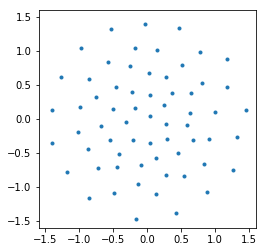

In [14]:
latestConstellation = sess.run(enc_seed, feed_dict=feedDict)
plt.plot(latestConstellation[:,0],latestConstellation[:,1],'.')
plt.axis('square');
lim_ = 1.6
plt.xlim(-lim_,lim_);
plt.ylim(-lim_,lim_);

In [15]:
if trainingParam.saveWeights:
    if not os.path.exists(trainingParam.path):
        os.makedirs(trainingParam.path)
    myVars = {re.sub(r'\/|\:\d','',x.name):x.eval(session=sess) for x in tf.trainable_variables()}
    fName = 'NNvars_{}'.format(trainingParam.filename)
    scipy.io.savemat(os.path.join(trainingParam.path,fName), myVars)

In [16]:
import claude.tx as tx
import claude.models.NLIN as nlin
nlinPowerSweep = np.arange(-8, 4+1, 0.1)

# System parameters
qamParam = p

# QAM
qam_constellation = np.squeeze(tx.qammod(chParam.M))
qamParam.kur, qamParam.kur3 = nlin.calcKur(qam_constellation)
qamEffSNR = nlinPowerSweep - nlin.calcNLIN(qamParam, nlinPowerSweep, aseNoisePower, interConst, intraConst, interConstAdd, intraConstAdd)

outSNR = sess.run(SNR)

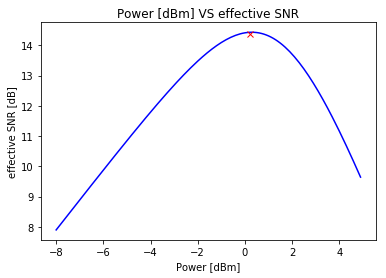

In [17]:
plt.plot(nlinPowerSweep, qamEffSNR, 'b')
plt.plot(outPdBm, outSNR, 'xr')
plt.title('Power [dBm] VS effective SNR')
plt.xlabel('Power [dBm]')
plt.ylabel('effective SNR [dB]')
plt.show()

In [18]:
qamMI = np.zeros(np.shape(qamEffSNR))
N = 5e4

for ii,p in enumerate(nlinPowerSweep):
    qamMI[ii] = cu.SNRtoMI(N, qamEffSNR[ii], np.expand_dims(qam_constellation, 0))

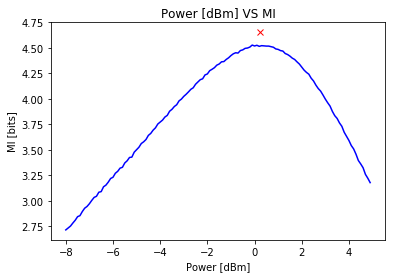

In [19]:
plt.plot(nlinPowerSweep, qamMI, 'b')
plt.plot(outPdBm, avGaussianMI, 'xr')
plt.title('Power [dBm] VS MI')
plt.xlabel('Power [dBm]')
plt.ylabel('MI [bits]')
plt.show()